`use_label_encoder` is deprecated in 1.7.0.


✅ XGBoost Accuracy: 0.8


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


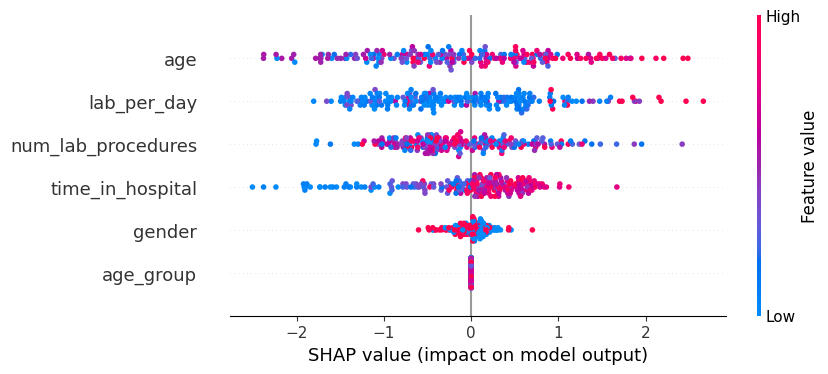

In [ ]:
import pandas as pd
import shap
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sqlalchemy import create_engine
import joblib

# Load data
engine = create_engine("sqlite:///../data/patient_readmission.db")
df = pd.read_sql("SELECT * FROM admission_features", engine)

# Feature engineering
df['lab_per_day'] = df['num_lab_procedures'] / df['time_in_hospital']
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 50, 70, 100], labels=[0, 1, 2, 3]).astype(int)

# Encode 'gender' if not already numeric
if df['gender'].dtype == 'O':
    df['gender'] = df['gender'].str.strip().str.capitalize()
    df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

# Drop unnecessary columns
df = df.drop(columns=['patient_id'])

# Split features and target
X = df.drop(columns=['readmitted'])
y = df['readmitted']

# One-hot encode categorical columns (if any remain)
X = pd.get_dummies(X, drop_first=True)

# Ensure all data is numeric and float
X = X.astype(float)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
scale = (y == 0).sum() / (y == 1).sum()  # balance weight
# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',scale_pos_weight=scale)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
xgb_pred = xgb_model.predict(X_test)
print("✅ XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))

# SHAP explanation
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# SHAP plot
shap.plots.beeswarm(shap_values)



In [25]:
import joblib

# Train your model
xgb_model.fit(X_train, y_train)

# ✅ Save the trained model, NOT the class
joblib.dump(xgb_model, '../model/best_model.pkl')


['../model/best_model.pkl']

In [26]:
print(y.value_counts(normalize=True))


readmitted
0    0.839
1    0.161
Name: proportion, dtype: float64
